In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_curve, 
                            roc_auc_score, 
                            confusion_matrix
                            )
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

/Users/kenn/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

### Want something like:

    SELECT
        table4.countrycode as 'countrycode',
        b.table1 as 'table1',
        b.table2 as 'table2',
        b.table3 as 'table3',
        table4.year as 'table4'
        (SELECT
            table3.countrycode as 'countrycode',
            a.table1 as 'table1',
            a.table2 as 'table2',
            table3.year as 'table3'
         FROM
            (SELECT
                 table1.countrycode as 'countrycode',
                 table1.year as 'table1',
                 table2.year as 'table2'
             FROM
                 table1
             JOIN
                 table2
               ON 
                 table1.countrycode = table2.countrycode
             ) a
         JOIN
             table3
           ON
             a.countrycode = table3.countrycode  
        ) b    
    JOIN
        table4
      ON
        a.countrycode = table3.countrycode 
    
        
       


In [3]:
def makeSQLQuery(table_names, year):
    dotyyear = '.y' + str(year)
    current_unit = 'a'
    query = '(SELECT ' + table_names[0] + '.countrycode AS countrycode, ' + \
            table_names[0] + dotyyear + ' AS ' + table_names[0] + ', ' + \
            table_names[1] + dotyyear + ' AS ' + table_names[1] + \
            ' FROM ' + table_names[0] + \
            ' JOIN ' + table_names[1] + \
            ' ON ' + table_names[0] + '.countrycode=' + table_names[1] + '.countrycode) '
    query = query + current_unit
    
    for table in table_names[2:]:
        curr_index = table_names.index(table)
        temp_list = table_names[:curr_index+1]
        
        pre_string = '(SELECT ' + table + '.countrycode as countrycode'
        
        for temp_table in temp_list[:-1]:
            pre_string = pre_string + ', ' + current_unit + '.' + temp_table + ' AS ' + temp_table
        
        pre_string = pre_string + ', ' + table + dotyyear + ' AS ' + table
        
        query = pre_string + ' FROM ' + query + ' JOIN ' + table + \
                ' ON ' + current_unit + '.countrycode=' + table + '.countrycode) '
        
        current_unit = current_unit + 'a'
        query = query + current_unit
        
    query = query.rsplit(' ', 1)[0][1:-1]
    
    return query
    
    

In [4]:
table_names = ['civil_liberties', 'population_growth', 'political_rights', \
               'life_expectancy', 'terror', 'peace', \
               'population_15_64',  \
                'zscores']

In [5]:
x_cols = table_names[:-1]

In [6]:
query = makeSQLQuery(table_names, 2012)

In [7]:
query

'SELECT zscores.countrycode as countrycode, aaaaaa.civil_liberties AS civil_liberties, aaaaaa.population_growth AS population_growth, aaaaaa.political_rights AS political_rights, aaaaaa.life_expectancy AS life_expectancy, aaaaaa.terror AS terror, aaaaaa.peace AS peace, aaaaaa.population_15_64 AS population_15_64, zscores.y2012 AS zscores FROM (SELECT population_15_64.countrycode as countrycode, aaaaa.civil_liberties AS civil_liberties, aaaaa.population_growth AS population_growth, aaaaa.political_rights AS political_rights, aaaaa.life_expectancy AS life_expectancy, aaaaa.terror AS terror, aaaaa.peace AS peace, population_15_64.y2012 AS population_15_64 FROM (SELECT peace.countrycode as countrycode, aaaa.civil_liberties AS civil_liberties, aaaa.population_growth AS population_growth, aaaa.political_rights AS political_rights, aaaa.life_expectancy AS life_expectancy, aaaa.terror AS terror, peace.y2012 AS peace FROM (SELECT terror.countrycode as countrycode, aaa.civil_liberties AS civil_l

In [8]:
data_2013 = pd.read_sql_query(query, engine)

In [9]:
data_2013 = data_2013.set_index('countrycode')

In [10]:
data_2013['zscores'] = data_2013['zscores'].astype(float)

In [11]:
data_2013.head()

,civil_liberties,population_growth,political_rights,life_expectancy,terror,peace,population_15_64,zscores
countrycode,,,,,,,,
AFG,6,3.135546,6,59.679610,8.735,3.375,51.199946,7.179031
AGO,5,3.331567,6,51.464000,1.349,2.099,49.544954,-0.220318
ALB,3,-0.147831,3,77.350463,0.134,1.972,68.570300,0.078938
ARE,6,2.463140,6,77.024146,0.248,1.735,85.549668,-0.287629
ARG,2,1.049809,2,75.816244,2.077,1.800,63.831465,-0.292320


In [12]:

data_2013.loc[data_2013['zscores'] > 0, 'zscores'] = 1
data_2013.loc[data_2013['zscores'] <= 0, 'zscores'] = 0

try:
    data_2013.loc[data_2013['freedom_status'] == 'F', 'freedom_status'] = -1
    data_2013.loc[data_2013['freedom_status'] == 'PF', 'freedom_status'] = 0
    data_2013.loc[data_2013['freedom_status'] == 'NF', 'freedom_status'] = 1
except:
    pass


In [13]:
#The rows to be dropped
data_2013[data_2013.isnull().any(axis=1)]

,civil_liberties,population_growth,political_rights,life_expectancy,terror,peace,population_15_64,zscores
countrycode,,,,,,,,
LKA,4,NaN,5,74.068049,4.651,2.192,66.774724,1


In [14]:
data_2013 = data_2013.dropna()

In [15]:
#Get Z scores of rows
for col in x_cols:
    data_2013[col] = (data_2013[col] - data_2013[col].mean())/data_2013[col].std(ddof=0)


In [16]:
def getScoreValues(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model=KNeighborsClassifier(n_neighbors=6), 
                   verbose=True, 
                   get_features=True
                  ):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)  
    
    feature_importances = None
    if get_features:
        try:
            feature_importances = model.feature_importances_
            #print(feature_importances)
        except AttributeError:
            pass
    
    if verbose:
        #print(pd.concat([y_test,pd.Series(y_pred, index=y_test.index)], axis = 1))
        print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(accuracy_score_value, \
                                                                       precision_score_value, \
                                                                       recall_score_value, \
                                                                       f1_score_value))
    
    return accuracy_score_value, precision_score_value, recall_score_value, f1_score_value, feature_importances

In [17]:
X = data_2013[x_cols]
y = data_2013['zscores']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [18]:
getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

Accuracy: 0.851063829787234
Precision: 0.5
Recall: 0.42857142857142855
f1: 0.4615384615384615


(0.85106382978723405,
 0.5,
 0.42857142857142855,
 0.46153846153846151,
 array([ 0.        ,  0.16242563,  0.08034793,  0.        ,  0.24630829,
         0.39578849,  0.11512965]))

In [19]:
getScoreValues(X_train, X_test, y_train, y_test, BernoulliNB())

Accuracy: 0.7659574468085106
Precision: 0.3
Recall: 0.42857142857142855
f1: 0.3529411764705882


(0.76595744680851063,
 0.29999999999999999,
 0.42857142857142855,
 0.3529411764705882,
 None)

In [20]:
getScoreValues(X_train, X_test, y_train, y_test, GaussianNB())

Accuracy: 0.7021276595744681
Precision: 0.18181818181818182
Recall: 0.2857142857142857
f1: 0.2222222222222222


(0.7021276595744681,
 0.18181818181818182,
 0.2857142857142857,
 0.22222222222222221,
 None)

In [21]:
getScoreValues(X_train, X_test, y_train, y_test, model=SVC())

Accuracy: 0.8297872340425532
Precision: 0.0
Recall: 0.0
f1: 0.0


(0.82978723404255317, 0.0, 0.0, 0.0, None)

In [22]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.7872340425531915
Precision: 0.0
Recall: 0.0
f1: 0.0


(0.78723404255319152,
 0.0,
 0.0,
 0.0,
 array([ 0.07882321,  0.15813493,  0.04734019,  0.11204826,  0.10302255,
         0.28134741,  0.21928345]))

In [23]:
def getROCcurve(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=6)):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
    print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc='best')

AUC: 0.7089285714285715


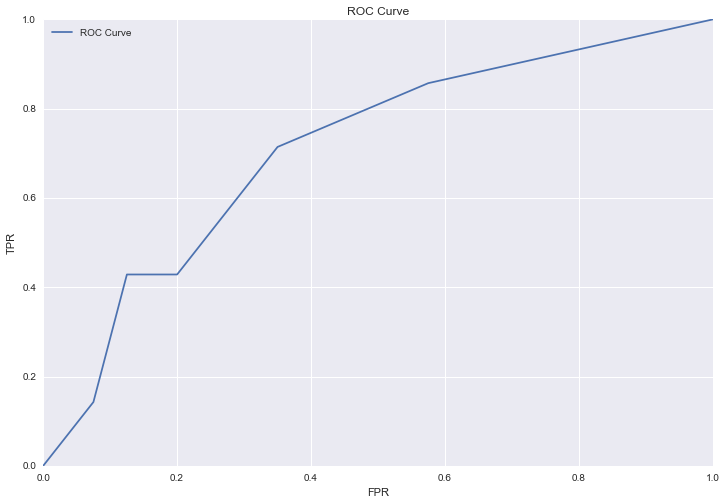

In [24]:
getROCcurve(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

In [25]:
def getScoreValuesByCV(X, y, model=KNeighborsClassifier(n_neighbors=5)):
    
    accuracy_score_value = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    precision_score_value = np.mean(cross_val_score(model, X, y, scoring='precision', cv=5))
    recall_score_value = np.mean(cross_val_score(model, X, y, scoring='recall', cv=5))
    f1_score_value = np.mean(cross_val_score(model, X, y, scoring='f1', cv=5))
    roc_auc_value = np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=5))
    #roc_auc_value = 0  
        
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(accuracy_score_value, \
                                                                   precision_score_value, \
                                                                   recall_score_value, \
                                                                   f1_score_value,
                                                                   roc_auc_value))

In [26]:
getScoreValuesByCV(X,y)

Accuracy: 0.8651209677419356
Precision: 0.6533333333333333
Recall: 0.42000000000000004
f1: 0.49936507936507935
ROC AUC: 0.7162820512820512


In [27]:
getScoreValuesByCV(X,y, model=RandomForestClassifier())

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.833266129032258
Precision: 0.43
Recall: 0.18666666666666668
f1: 0.20714285714285716
ROC AUC: 0.7057692307692307


In [28]:
getScoreValuesByCV(X,y, model=GaussianNB())

Accuracy: 0.7820564516129032
Precision: 0.3873809523809524
Recall: 0.5066666666666667
f1: 0.43074925074925074
ROC AUC: 0.7051282051282051


In [29]:
getScoreValuesByCV(X,y, model=DecisionTreeClassifier())

Accuracy: 0.7439516129032258
Precision: 0.275
Recall: 0.4666666666666667
f1: 0.285034965034965
ROC AUC: 0.601025641025641


In [30]:
getScoreValuesByCV(X,y, model=LogisticRegression())

Accuracy: 0.8268145161290323
Precision: 0.4333333333333333
Recall: 0.15333333333333332
f1: 0.21428571428571427
ROC AUC: 0.6987179487179487


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Over sampling

In [31]:
X = data_2013[x_cols]
y = data_2013['zscores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [32]:
verbose = False
ratio = float(y.value_counts()[0]) / float(y.value_counts()[1])
X_train = X_train.reset_index(drop=True).as_matrix()
y_train = y_train.reset_index(drop=True).as_matrix()

smote = SMOTE(ratio=ratio, verbose=verbose)
smox, smoy = smote.fit_transform(X_train, y_train)

In [33]:
#smox

In [34]:
X_train = pd.DataFrame(smox, columns=x_cols)
y_train = pd.Series(smoy)

In [35]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.7446808510638298
Precision: 0.0
Recall: 0.0
f1: 0.0


(0.74468085106382975,
 0.0,
 0.0,
 0.0,
 array([ 0.10096807,  0.09414772,  0.1251282 ,  0.16846919,  0.15714579,
         0.22377834,  0.13036268]))

In [36]:
getScoreValues(X_train, X_test, y_train, y_test, model=BernoulliNB())

Accuracy: 0.6382978723404256
Precision: 0.2222222222222222
Recall: 0.5714285714285714
f1: 0.32


(0.63829787234042556,
 0.22222222222222221,
 0.5714285714285714,
 0.32000000000000001,
 None)

In [37]:
getScoreValues(X_train, X_test, y_train, y_test, model=GaussianNB())

Accuracy: 0.6595744680851063
Precision: 0.2
Recall: 0.42857142857142855
f1: 0.27272727272727276


(0.65957446808510634,
 0.20000000000000001,
 0.42857142857142855,
 0.27272727272727276,
 None)

In [38]:
getScoreValues(X_train, X_test, y_train, y_test, model=DecisionTreeClassifier())

Accuracy: 0.7659574468085106
Precision: 0.0
Recall: 0.0
f1: 0.0


(0.76595744680851063,
 0.0,
 0.0,
 0.0,
 array([ 0.14003629,  0.01791759,  0.14772695,  0.04872572,  0.12705854,
         0.33707088,  0.18146403]))

In [39]:
getScoreValues(X_train, X_test, y_train, y_test)

Accuracy: 0.7446808510638298
Precision: 0.3333333333333333
Recall: 0.7142857142857143
f1: 0.4545454545454545


(0.74468085106382975,
 0.33333333333333331,
 0.7142857142857143,
 0.45454545454545447,
 None)

## Confusion Matrix

In [40]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not at Risk', 'At Risk'], rotation=45)
    plt.yticks(tick_marks, ['Not at Risk', 'At Risk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Cross validate with oversampling

In [41]:
def getCrossValScoresBySSS(local_X, 
                           local_y, 
                           n_iter=30, 
                           test_size=0.3, 
                           model=KNeighborsClassifier(n_neighbors=3),
                           get_multi_models=False,
                           get_models_avg=False,
                           get_cm=False,
                           verbose=True,
                           get_features=True
                          ):
    
    score_dict = {}
    acc_array = []
    prec_array = []
    recall_array = []
    f1_array = []
    feature_imp_array = []
    
    x_cols = list(local_X.columns)
    ratio = float(local_y.value_counts()[0]) / (.75*float(local_y.value_counts()[1]))
    sss = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size)
    
    model_list = [\
                  KNeighborsClassifier(n_neighbors=3), \
                  LogisticRegression(), \
                  BernoulliNB(), \
                  GaussianNB(), \
                  RandomForestClassifier(), \
                  DecisionTreeClassifier() \
                  ]
    
    #Return table of scores for each model
    if get_multi_models:
        model_acc = []
        model_prec = []
        model_rec = []
        model_f1 = []
        for a_model in model_list:
            acc_array = []
            prec_array = []
            recall_array = []
            f1_array = []
            for train_index, test_index in sss:
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = X.ix[train_index], X.ix[test_index]
                y_train, y_test = y.ix[train_index], y.ix[test_index]

                X_train = X_train.reset_index(drop=True).as_matrix()
                y_train = y_train.reset_index(drop=True).as_matrix()

                smote = SMOTE(ratio=ratio, verbose=False)
                smox, smoy = smote.fit_transform(X_train, y_train)
                X_train = pd.DataFrame(smox, columns=x_cols)
                y_train = pd.Series(smoy)
            
                accuracy_score_value, precision_score_value, \
                recall_score_value, f1_score_value, _ = getScoreValues(X_train, 
                                                                   X_test, 
                                                                   y_train, 
                                                                   y_test, 
                                                                   model=a_model, 
                                                                   verbose=False,
                                                                   get_features=False)
                
                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)
                
            mean_acc = np.mean(acc_array)
            mean_prec = np.mean(prec_array)
            mean_recall = np.mean(recall_array)
            mean_f1 = np.mean(f1_array)
            
            model_acc.append(mean_acc)
            model_prec.append(mean_prec)
            model_rec.append(mean_recall)
            model_f1.append(mean_f1)
            
        score_dict['Accuracy'] = model_acc
        score_dict['Precision'] = model_prec
        score_dict['Recall'] = model_rec
        score_dict['F1'] = model_f1
        
        col_names = ['Accuracy', 'Precision', 'Recall', 'F1']
        index_func = [\
                  'KNeighborsClassifier(n_neighbors=3)', \
                  'LogisticRegression()', \
                  'BernoulliNB()', \
                  'GaussianNB()', \
                  'RandomForestClassifier()', \
                  'DecisionTreeClassifier()' \
                  ]
        df = pd.DataFrame(score_dict, columns=col_names, index=index_func)
        return df
    
    
    else:
        for train_index, test_index in sss:
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.ix[train_index], X.ix[test_index]
            y_train, y_test = y.ix[train_index], y.ix[test_index]

            X_train = X_train.reset_index(drop=True).as_matrix()
            y_train = y_train.reset_index(drop=True).as_matrix()

            smote = SMOTE(ratio=ratio, verbose=False)
            smox, smoy = smote.fit_transform(X_train, y_train)
            X_train = pd.DataFrame(smox, columns=x_cols)
            y_train = pd.Series(smoy)

            #Get scores of the average prediction of multiple models
            if get_models_avg:
                y_predictions = []

                for a_model in model_list:
                    temp_model = a_model
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    y_predictions.append(y_pred)

                average_prediction = np.mean(y_predictions, axis=0)
                average_prediction = [int(round(n, 0)) for n in average_prediction]

                accuracy_score_value = accuracy_score(y_test, y_pred)
                precision_score_value = precision_score(y_test, y_pred)
                recall_score_value = recall_score(y_test, y_pred)
                f1_score_value = f1_score(y_test, y_pred)

                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)

            #Get score values for each fold
            else:
                accuracy_score_value, precision_score_value, \
                recall_score_value, f1_score_value, \
                feature_importances = getScoreValues(X_train, 
                                                     X_test, 
                                                     y_train,
                                                     y_test, 
                                                     model=model, 
                                                     verbose=False,
                                                     get_features=get_features)

                if get_cm:
                    # For getting a confusion matrix of the last model in the cross validated set
                    temp_model = model
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)

                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)
                feature_imp_array.append(feature_importances)

        if get_cm:
            try:
                cm = confusion_matrix(y_test, average_prediction)
            except:
                cm = confusion_matrix(y_test, y_pred)
            plt.figure()
            plot_confusion_matrix(cm)

        mean_acc = np.mean(acc_array)
        mean_prec = np.mean(prec_array)
        mean_recall = np.mean(recall_array)
        mean_f1 = np.mean(f1_array)
        try:
            mean_feature_imp = np.mean(feature_imp_array, axis=0)
        except TypeError:
            mean_feature_imp = None
            
            
        if verbose:
            print('Avg Feature Importance: {}'.format(mean_feature_imp))
            print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(mean_acc, \
                                                                           mean_prec, \
                                                                           mean_recall,\
                                                                           mean_f1))

In [42]:
X = data_2013[x_cols]
y = data_2013['zscores']

## Scores for various models

In [49]:
getCrossValScoresBySSS(X, y, get_multi_models=True)

,Accuracy,Precision,Recall,F1
KNeighborsClassifier(n_neighbors=3),0.725532,0.353433,0.675000,0.457840
LogisticRegression(),0.568085,0.233039,0.683333,0.345692
BernoulliNB(),0.570922,0.227998,0.637500,0.333486
GaussianNB(),0.579433,0.231847,0.650000,0.339790
RandomForestClassifier(),0.800709,0.435111,0.404167,0.403197
DecisionTreeClassifier(),0.730496,0.267953,0.345833,0.296649


#### KNN various n


n =  1
Avg Feature Importance: None
Accuracy: 0.7652482269503547
Precision: 0.3857372475019535
Recall: 0.5666666666666667
f1: 0.45144822891222147


n =  2
Avg Feature Importance: None
Accuracy: 0.7836879432624112
Precision: 0.4097392422392423
Recall: 0.575
f1: 0.47215680544459654


n =  3
Avg Feature Importance: None
Accuracy: 0.7113475177304964
Precision: 0.3295670619083932
Recall: 0.6291666666666667
f1: 0.42610169897158534


n =  4
Avg Feature Importance: None
Accuracy: 0.7404255319148937
Precision: 0.36424975202031346
Recall: 0.675
f1: 0.46700984568310905


n =  5
Avg Feature Importance: None
Accuracy: 0.6886524822695036
Precision: 0.331357041126133
Recall: 0.775
f1: 0.4599366158111344


n =  6
Avg Feature Importance: None
Accuracy: 0.7070921985815602
Precision: 0.3427678207012573
Recall: 0.7208333333333333
f1: 0.4572399212441026


n =  7
Avg Feature Importance: None
Accuracy: 0.6553191489361703
Precision: 0.30614290120273435
Recall: 0.7541666666666667
f1: 0.4319636894982448




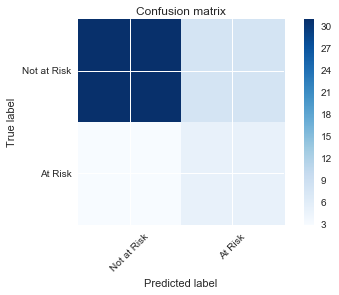

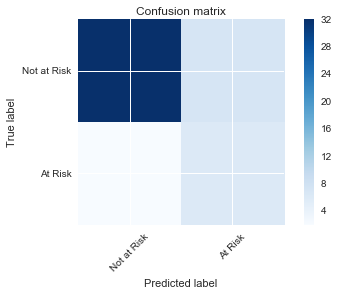

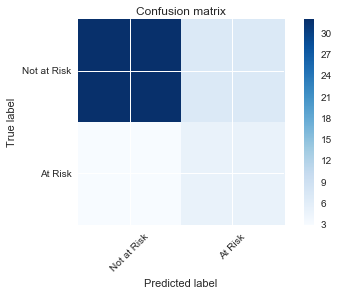

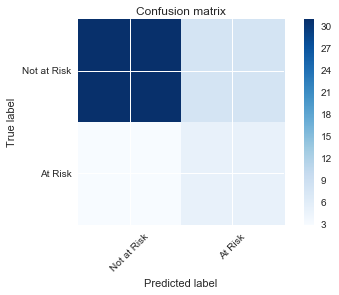

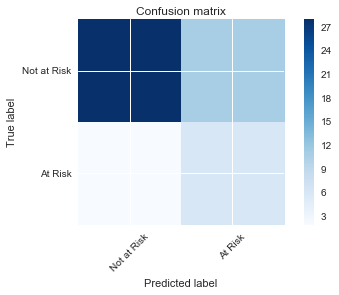

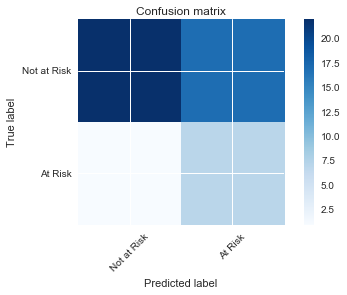

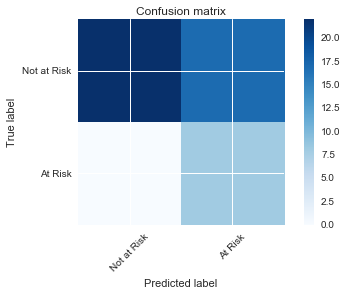

In [44]:
for n in range(1,8):
    print('n = ', n)
    getCrossValScoresBySSS(X, y, model=KNeighborsClassifier(n_neighbors=n), get_cm=True)
    print('\n')

#### Random Forest for important features

Avg Feature Importance: [ 0.14163002  0.12234195  0.15202144  0.15103991  0.14836891  0.14325412
  0.14134366]
Accuracy: 0.8198581560283686
Precision: 0.47037823287823294
Recall: 0.4041666666666667
f1: 0.42294642148357314


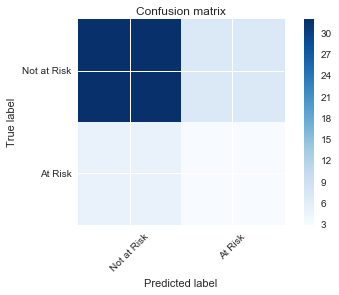

In [45]:
getCrossValScoresBySSS(X, y, model=RandomForestClassifier(), get_cm = True)

#### DecisionTreeClassifier for important features

Avg Feature Importance: [ 0.12265845  0.17058125  0.22776997  0.10239372  0.1660441   0.08149094
  0.12906156]
Accuracy: 0.7255319148936171
Precision: 0.26392076333252806
Recall: 0.32083333333333336
f1: 0.27882697601825346


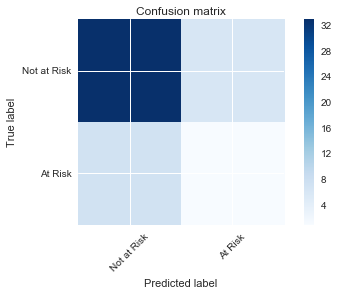

In [48]:
getCrossValScoresBySSS(X, y, model=DecisionTreeClassifier(), get_cm = True)

### Model averages:

In [47]:
getCrossValScoresBySSS(X, y, get_models_avg=True)

Avg Feature Importance: nan
Accuracy: 0.7163120567375889
Precision: 0.34351528429617684
Recall: 0.6875
f1: 0.4513632644852184


/Users/kenn/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
